<a href="https://colab.research.google.com/github/Alf-caput/P1_MineriaDeDatos/blob/dev1/Copia_de_P3_ReduccionDimensionalidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importamos las dependencias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Cargamos desde el repositorio de github los datos

In [ ]:
url = 'https://github.com/Alf-caput/P1_MineriaDeDatos/raw/main/P3_ReduccionDimensionalidad/USA.xlsx'
df = pd.read_excel(url)
df.head()

,Ciudad,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
0,Phoenix,10.0,70.3,213.0,582.0,6.0,7.05,36.0
1,Little Rock,13.0,61.0,91.0,132.0,8.2,48.52,100.0
2,San Francisco,12.0,56.7,453.0,716.0,8.7,20.66,67.0
3,Denver,17.0,51.9,454.0,515.0,9.0,12.95,86.0
4,Hartford,56.0,49.1,412.0,158.0,9.0,43.37,127.0


Con df.info() podemos ver el tamaño del dataset, valores no nulos y tipos de las variables

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ciudad     41 non-null     object 
 1   SO2        41 non-null     float64
 2   Neg.Temp   41 non-null     float64
 3   Empresas   41 non-null     float64
 4   Poblacion  41 non-null     float64
 5   Viento     41 non-null     float64
 6   Precip     41 non-null     float64
 7   Dias       41 non-null     float64
dtypes: float64(7), object(1)
memory usage: 2.7+ KB


Se trata de un set de datos sobre ciudades, las variables del mismo son:

In [ ]:
df.columns

Index(['Ciudad', 'SO2', 'Neg.Temp', 'Empresas', 'Poblacion', 'Viento',
       'Precip', 'Dias'],
      dtype='object')

Parece que tiene que ver con mediciones del ambiente y demografía en ciudades.\
Buscando documentación online encontramos el valor de los datos:
- Ciudad, nombre de ciudad (EEUU)
- SO2, contenido en SO2
- Neg.Temp, temperatura Fahrenheit
- Empresas, número de empresas con más de 20 trabajadores
- Poblacion, en miles de habitantes
- Viento, velocidad media del viento
- Precip, precipitación anual media
- Dias, número de días lluviosos al año

Con df.info() se podía ver que el número de no nulos coincide con el número de filas, no obstante para datasets más grandes podríamos comprobar el número de NA con:

In [ ]:
pd.DataFrame({'Valores NA': df.isna().sum()})

,Valores NA
Ciudad,0
SO2,0
Neg.Temp,0
Empresas,0
Poblacion,0
Viento,0
Precip,0
Dias,0


En df.info() nos fijamos que son float64 excepto los valores que toma la variable ciudad que son strings (pandas por defecto considera strings como tipo obj)\
A simple vista parece que las ciudades del dataset son únicas, lo podemos comprobar:

In [ ]:
df.loc[:, 'Ciudad'].nunique() == len(df.loc[:, 'Ciudad'])

True

Utilizaremos el nombre de la ciudad como índice de fila (es conveniente para estandarizar el resto de variables)

In [ ]:
df = df.set_index('Ciudad')
df.head()

,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
Ciudad,,,,,,,
Phoenix,10.0,70.3,213.0,582.0,6.0,7.05,36.0
Little Rock,13.0,61.0,91.0,132.0,8.2,48.52,100.0
San Francisco,12.0,56.7,453.0,716.0,8.7,20.66,67.0
Denver,17.0,51.9,454.0,515.0,9.0,12.95,86.0
Hartford,56.0,49.1,412.0,158.0,9.0,43.37,127.0


Para hacernos una idea de los datos y ver rangos usamos .describe()\
Nota: Eliminamos la columna conteo y transponemos para que quede más legible

In [ ]:
df.describe().drop('count').T

,mean,std,min,25%,50%,75%,max
SO2,30.048780,23.472272,8.00,13.00,26.00,35.00,110.0
Neg.Temp,55.763415,7.227716,43.50,50.60,54.60,59.30,75.5
Empresas,463.097561,563.473948,35.00,181.00,347.00,462.00,3344.0
Poblacion,608.609756,579.113023,71.00,299.00,515.00,717.00,3369.0
Viento,9.443902,1.428644,6.00,8.70,9.30,10.60,12.7
Precip,36.769024,11.771550,7.05,30.96,38.74,43.11,59.8
Dias,113.902439,26.506419,36.00,103.00,115.00,128.00,166.0


Por una parte no observamos valores carentes de sentido, como una cantidad de días negativa o una tempertatura extraña.

Por otro lado como no conocemos bien el dominio del problema y no contamos con gran cantidad de datos, no eliminaremos posibles outliers, que podemos observar con boxplots:

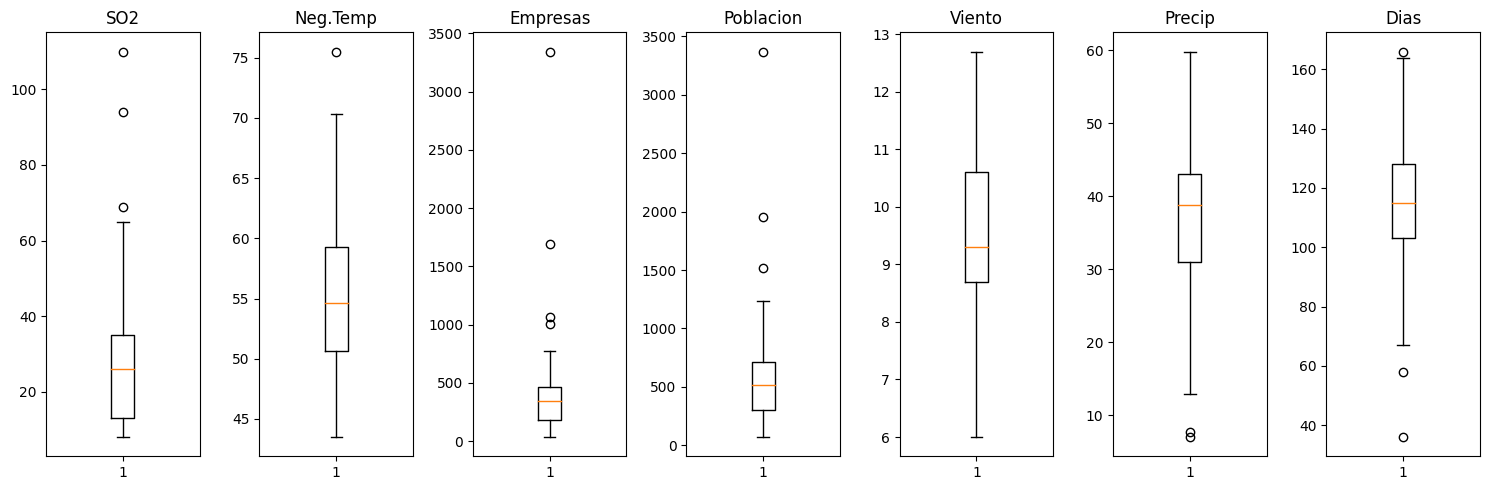

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(15, 5))

for i, columna in enumerate(df.columns):
    axs[i].boxplot(df[columna])
    axs[i].set_title(columna)

plt.tight_layout()

plt.show()

Para poder interpretar los resultados de forma correcta, se realizará una breve explicación sobre el rango intercuartílico(IQR).El IQR abarca el rango medio del conjunto de datos, representando el 50% central de las observaciones.

 En un gráfico de cajas, la "caja" en sí representa el rango intercuartílico. La línea que divide la caja en dos partes es la mediana (Q2), que indica la posición central de los datos. Las "líneas whisker" (bigotes) que se extienden desde la caja representan el rango completo de los datos, excluyendo valores extremos o atípicos. ¿Y como se determinan dichos valores extremos o atípicos?

IQR = Q3 - Q1

Una vez determinado el IQR, se empleará "la regla de los 1.5* IQR". Esto es: cualquier valor que esté por debajo del primer cuartil menos el rango intercuartílico por 1.5 (Q1-IQR*1.5) y cualquier valor que este por encima del tercer cuartil más el rango intercuartílico por 1.5 (Q3 + IQR*1.5).

En suma, cualquier valor que cumpla dichas condiciones representa un valor significativamente alejado de la mayoría del conjunto de datos.






In [ ]:
# Calcular el rango intercuartílico (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
# Calcular los límites para identificar valores atípicos
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

mask = (df['Dias'] < lower_limit) | (df['Dias'] > upper_limit)
df[mask]

<ipython-input-12-ec1213153d19>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
<ipython-input-12-ec1213153d19>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)


ValueError: Can only compare identically-labeled Series objects

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


# Leer los datos desde la URL
url = 'https://github.com/Alf-caput/P1_MineriaDeDatos/raw/main/P3_ReduccionDimensionalidad/USA.xlsx'
df = pd.read_excel(url)

# Calcular el rango intercuartílico (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
# Calcular los límites para identificar valores atípicos
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR
print(type(lower_limit))
type(upper_limit)

# Identificar valores atípicos
outliers = (df < lower_limit) | (df > upper_limit)

# Mostrar los índices de las filas que contienen valores atípicos
outliers_indices = outliers.any(axis=1)
outliers_indices = outliers_indices[outliers_indices].index
print("Índices de filas con valores atípicos:")
print(outliers_indices)

# Acceder a los datos correspondientes a los índices de valores atípicos
outliers_data = df.loc[outliers_indices]

# Mostrar los datos correspondientes a los valores atípicos
#print("Datos correspondientes a los valores atípicos:")
#print(outliers_data)

# Identificar y mostrar los valores atípicos
outliers_values = df[outliers]

print("Valores atípicos:")
print(outliers_values)

# Identificar y mostrar solo los valores atípicos
outliers_values = df.where(outliers)

# Convertir True/False a 1/0 y mostrar los valores atípicos
outliers_values = outliers.astype(int)

print("Valores atípicos marcados como 1, valores no atípicos marcados como 0:")
print(outliers_values)

# Eliminar las filas que solo contienen "0"
outliers_removed = outliers_values[(outliers_values.sum(axis=1) != 0)]

print("Filas con outliers eliminados:")
print(outliers_removed)







<class 'pandas.core.series.Series'>
Índices de filas con valores atípicos:
Int64Index([0, 8, 10, 17, 22, 24, 26, 28, 30], dtype='int64')
Valores atípicos:
   Ciudad    SO2  Neg.Temp  Empresas  Poblacion  Viento  Precip   Dias
0     NaN    NaN       NaN       NaN        NaN     NaN    7.05   36.0
1     NaN    NaN       NaN       NaN        NaN     NaN     NaN    NaN
2     NaN    NaN       NaN       NaN        NaN     NaN     NaN    NaN
3     NaN    NaN       NaN       NaN        NaN     NaN     NaN    NaN
4     NaN    NaN       NaN       NaN        NaN     NaN     NaN    NaN
5     NaN    NaN       NaN       NaN        NaN     NaN     NaN    NaN
6     NaN    NaN       NaN       NaN        NaN     NaN     NaN    NaN
7     NaN    NaN       NaN       NaN        NaN     NaN     NaN    NaN
8     NaN    NaN      75.5       NaN        NaN     NaN     NaN    NaN
9     NaN    NaN       NaN       NaN        NaN     NaN     NaN    NaN
10    NaN  110.0       NaN    3344.0     3369.0     NaN     NaN 

<ipython-input-17-f38c54077c66>:11: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
<ipython-input-17-f38c54077c66>:12: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
<ipython-input-17-f38c54077c66>:21: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = (df < lower_limit) | (df > upper_limit)


### 1.- (1 punto) Estandarizar los datos

Estandarizamos el dataframe, para pasar todas las variables al mismo rango, para ello nos serviremos de un objeto scaler obtenido de sklearn.preprocessing.StandardScaler\
Los nuevos datos estandarizados se meten en un nuevo pandas.DataFrame

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_std = scaler.fit_transform(df)

df_std = pd.DataFrame(df_std, columns=df.columns, index=df.index)
df_std.head()

Generamos estadísticas con .describe().\
(Para que se muestren resultados con 2 decimales se usa un context manager que cambia la configuración del display y una vez se termina el bloque with devuelve a la configuración inicial)

In [ ]:
class Notation2Decimal:
    def __enter__(self):
        self.original_config = pd.get_option('display.float_format')
        pd.set_option('display.float_format', lambda x: '%.2f' % x)

    def __exit__(self, exc_type, exc_value, traceback):
        pd.set_option('display.float_format', self.original_config)

with Notation2Decimal():
    print(df_std.describe().drop('count').T)

Vemos que las variables se encuentran en un rango con media 0 y desviación típica 1.\
(No son exactos por problemas de redondeo)

### 2.- (1 punto) Obtención de autovalores y autovectores

In [ ]:
df_std.head()

Sobre el dataframe estandarizado (df_std) obtenemos la matriz de correlación (df_corr)

In [ ]:
df_corr = df_std.corr()
df_corr

Usando la librería seaborn podemos con una línea de código mostrar las correlaciones de manera gráfica

In [ ]:
import seaborn as sns
sns.heatmap(df_corr, cmap='RdBu', vmin=-1, vmax=1, annot=True)
plt.title('Mapa de Calor - Matriz de Correlación')
plt.show()

Para obtener los autovalores y autovectores utilizamos linalg.eig de numpy, una vez obtenidos los reordenamos de mayor a menor:

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(df_corr.values)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
eigenvalues

Calculamos la varianza explicada (y su acumulación) por cada una de las nuevas componentes y lo mostramos en un dataframe

In [ ]:
variance_perc = (eigenvalues * 100 / np.sum(eigenvalues))
acc_variance_perc = np.cumsum(variance_perc)
comp_index = pd.Index((f'PC{i+1}' for i in range(len(eigenvalues))), name='Componentes')

df_variance = pd.DataFrame({
    'Autovalor': eigenvalues,
    'Varianza explicada(%)': variance_perc,
    'Varianza acumulada(%)': acc_variance_perc},
    index=comp_index)

with Notation2Decimal():
    print(df_variance)

Gráficamente se entiende de manera más intuitiva:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

x = df_variance.index
y = df_variance.loc[:, 'Varianza explicada(%)']
y_cum = df_variance.loc[:, 'Varianza acumulada(%)']

ax = y_cum.plot(kind='bar', color='lime', alpha=0.3)
for i, valor in enumerate(y_cum):
    plt.text(i, valor, f'{valor:.2f}%', ha='center', va='bottom')

ax = y.plot(kind='bar')
for i, valor in enumerate(y):
    # Acumulada[0] == Individual[0] omit first Acumulada
    if i:
        plt.text(i, valor, f'{valor:.2f}%', ha='center', va='bottom')

# Rotate labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.xlabel('Componente')
plt.ylabel('Varianza explicada(%)')
plt.title('PCA - Varianza explicada')
plt.legend(['Varianza acumulada', 'Varianza individual'], loc='best')
plt.show()

¿Cuánta información perdemos con 2 componentes?

In [ ]:
num_comp = 2
info_loss = 100-df_variance.loc[f"PC{num_comp}", "Varianza acumulada(%)"]
print(f'Con {num_comp} componentes perdemos un {info_loss:.2f}%')

¿Cuánta información representamos con 3 componentes?

In [ ]:
num_comp = 3
info = df_variance.loc[f"PC{num_comp}", "Varianza acumulada(%)"]
print(f'Con {num_comp} componentes representamos un {info:.2f}%')

##### 3.- (1 punto)Obtén un diagrama de dispersión en 3 dimensiones y comenta qué has interpretado en él. Elige al menos 4 ciudades de forma aleatoria y explica qué pasa con ellas.

En coordenadas de las 3 primeras componentes principales los datos quedan como sigue:

In [ ]:
num_comp = 3
comp_index = pd.Index(f'PC{i+1}' for i in range(num_comp))

df_pca = pd.DataFrame(
    data=np.dot(df_std, eigenvectors[:, :num_comp]),
    columns=comp_index,
    index=df_std.index)

with Notation2Decimal():
    print(df_pca.head())

Si elegimos 3 componentes principales los 3 autovectores asociados nos dan información sobre las variables iniciales

In [ ]:
num_comp = 3
comp_index = pd.Index(f'PC{i+1}' for i in range(num_comp))

df_3eig = pd.DataFrame(data=eigenvectors[:, :num_comp], index=df_std.columns, columns=comp_index)
with Notation2Decimal():
    print(df_3eig)

Podemos representar las componentes principales contra sí mismas, en 2 dimensiones

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(df_pca['PC1'], df_pca['PC2'], color='lightblue')
for i, variable in enumerate(df_std.columns):
    x, y, z = np.zeros(3)
    u, v, w = eigenvectors[i, :3] * 3
    axs[0].arrow(x, y, u, v, color='r', alpha=0.7, head_width=0.05, head_length=0.05)
    axs[0].text(u, v, variable, color='k', ha='right', va='bottom', fontsize=8)
    axs[0].set_xlabel('PC1')
    axs[0].set_ylabel('PC2')

axs[1].scatter(df_pca['PC1'], df_pca['PC3'], color='lightblue')
for i, variable in enumerate(df_std.columns):
    x, y, z = np.zeros(3)
    u, v, w = eigenvectors[i, :3] * 3
    axs[1].arrow(x, z, u, w, color='r', alpha=0.7, head_width=0.05, head_length=0.05)
    axs[1].text(u, w, variable, color='k', ha='right', va='bottom', fontsize=8)
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC3')

axs[2].scatter(df_pca['PC2'], df_pca['PC3'], color='lightblue')
for i, variable in enumerate(df_std.columns):
    x, y, z = np.zeros(3)
    u, v, w = eigenvectors[i, :3] * 3
    axs[2].arrow(y, z, v, w, color='r', alpha=0.7, head_width=0.05, head_length=0.05)
    axs[2].text(v, w, variable, color='k', ha='right', va='bottom', fontsize=8)
    axs[2].set_xlabel('PC2')
    axs[2].set_ylabel('PC3')


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
num_comp = 3
scale_factor = 3
pc_eigenvectors = eigenvectors[:, :num_comp] * scale_factor
pc_axs = {'PC1': 0, 'PC2': 1, 'PC3': 2}
for i, (x, y) in enumerate([('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]):
    axs[i].scatter(df_pca[x], df_pca[y], color='lightblue')
    for j, variable in enumerate(df_std.columns):
        # Components of the eigenvector (same as coords of initial variables) in pc_axs[x], pc_axs[y] dimensions
        u, v = pc_eigenvectors[j, pc_axs[x]], pc_eigenvectors[j, pc_axs[y]]
        axs[i].arrow(0, 0, u, v, color='r', alpha=0.7, head_width=0.05, head_length=0.05)
        axs[i].text(u, v, variable, color='k', ha='right', va='bottom', fontsize=8)
        axs[i].set_xlabel(x)
        axs[i].set_ylabel(y)


En 3 dimensiones queda:

In [ ]:
fig, ax = plt.subplots()
ax = plt.subplot(projection='3d')
ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'])
for i, variable in enumerate(df_std.columns):
    x, y, z = np.zeros(3)
    u, v, w = eigenvectors[i, :3] * 3
    plt.quiver(x, y, z, u, v, w, color='r')

Adicional: sklearn dispone del objeto PCA que consigue lo que hemos ido haciendo paso a paso

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_std)

variance_perc = pca.explained_variance_ratio_ * 100
acc_variance_perc = variance_perc.cumsum()
comp_index = pd.Index([f'PC{i+1}' for i in range(len(eigenvalues))], name='Componentes')

df_variance = pd.DataFrame({
    'Autovalor': eigenvalues,
    'Varianza explicada(%)': variance_perc,
    'Varianza Acumulada(%)': acc_variance_perc},
    index=comp_index)

with Notation2Decimal():
    print(df_variance)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Leer los datos desde la URL
url = 'https://github.com/Alf-caput/P1_MineriaDeDatos/raw/main/P3_ReduccionDimensionalidad/USA.xlsx'
df = pd.read_excel(url)

# Eliminar columnas no numéricas (en este caso, 'Ciudad')
df_numeric = df.drop(columns=['Ciudad'])

# Estandarizar los datos
scaler = StandardScaler()
df_std = scaler.fit_transform(df_numeric)

# Aplicar PCA
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_std)

# Crear un DataFrame para los componentes principales
df_pca = pd.DataFrame(data=df_pca, columns=['PC1', 'PC2', 'PC3'], index=df.index)

# Visualizar en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'])

# Añadir etiquetas
for i, ciudad in enumerate(df.index):
    ax.text(df_pca.loc[ciudad, 'PC1'], df_pca.loc[ciudad, 'PC2'], df_pca.loc[ciudad, 'PC3'], ciudad)

# Etiquetar ejes
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()
